# Лекция 4: Программная платформа Hadoop. Планировщик ресурсов YARN.


**Планирование задач** - это с точки зрения производительности, не должно быть узких бутылочных горлышков при обработки больших данных, чтобы у нас было своевременное оповещение управляющих узлов о том, что какой-то узел вышел из строя и следовательно не нужно его нагружать... В HDFS - это реализовано не полностью, он предназначен только для хранения задач, для планирования всей программы нужно, что-то более серьезное ЭТО КАК РАЗ ТАКИ `YARN`.

`YARN` - хорош только для определенного класстера задач. Для задач 1 пишет много читают YARN лучший в своем роде!

У него есть альтернативы - это kubernetes. 

**YARN** (Yet Another Resource Negotiator — «ещё один ресурсный посредник») — модуль,
отвечающий за управление ресурсами кластеров и планирование заданий. Если в
предыдущих выпусках эта функция была интегрирована в модуль <u>MapReduce</u>, где была
реализована единым компонентом (JobTracker), то в YARN функционирует логически
самостоятельный <u>демон</u> — планировщик ресурсов (ResourceManager), абстрагирующий
все вычислительные ресурсы кластера и управляющий их предоставлением
приложениям распределённой обработки. Работать под управлением YARN могут как
MapReduce-программы, так и любые другие распределённые приложения,
поддерживающие соответствующие программные интерфейсы; 

YARN обеспечивает возможность параллельного выполнения нескольких различных задач в рамках кластера
и их изоляцию. Разработчику распределённого приложения необходимо реализовать
специальный класс управления приложением (ApplicationMaster), который отвечает за
координацию заданий в рамках тех ресурсов, которые предоставит планировщик
ресурсов; 

планировщик ресурсов же отвечает за создание экземпляров класса
управления приложением и взаимодействия с ним через соответствующий сетевой
протокол.

### Что было до YARN?

MRv1 - MapReduce version 1

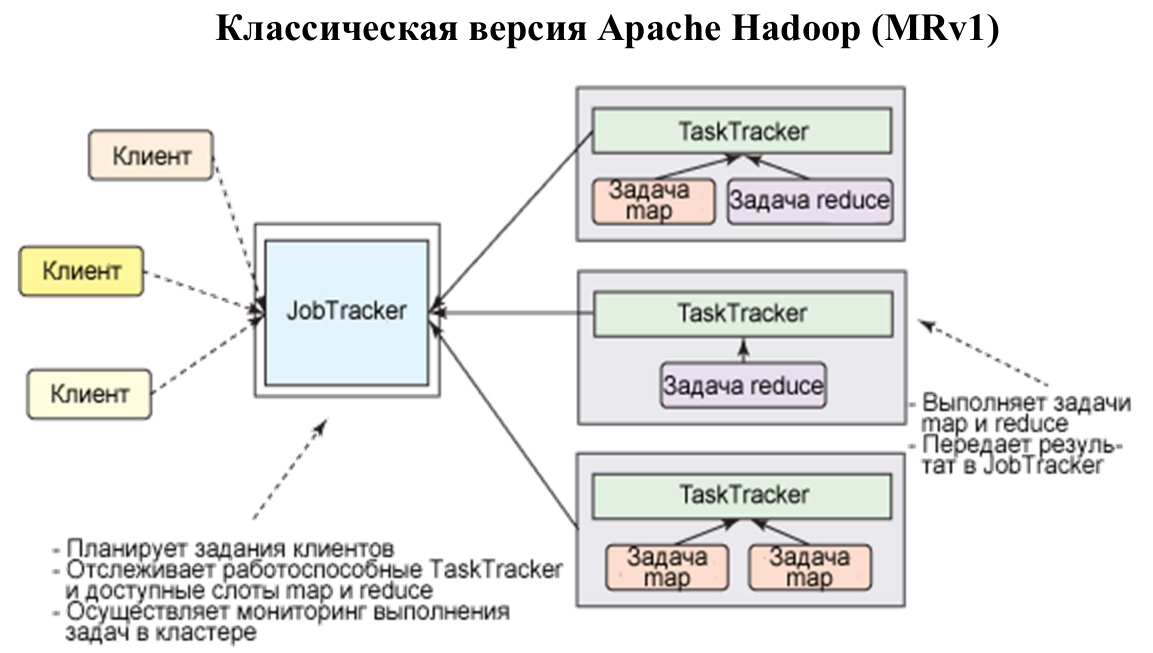

### Как происходит взаимодействие?

1) У нас есть много клиентов(служба взаимодействующая с человеком/клиентом), которые обращаются к JobTracker-у

2) JobTracker
- планировщик задач, который планирует задания клиентам.
- отслеживает работоспособные TaskTracker-ы - это службы развернутые на Worker-ах (DataNode-ах), которые управляют виртуальной машиной над DataNode-амию.
- осуществляет мониториг выполнения задач в кластере.

Для чего все это нужно было?
- Для того, чтобы выстраить задачи клиентов в очередь (у задач клиентов ценность задач может быть одинаковой, тогда они выстраиваются в очередь по мере поступления). У клиентов есть приоритеты.(В зависимости от этого и выстраивается очередь)
- Алгоритм построения очереди был не сложный: FIFO / LIFO или комбинация или с приоритезацией...

3)  Дальше происходило взаимодействие с TaskTraker-ом
- TaskTraker - это трекер, который отвечает за конкретные задачи.
- TaskTraker выполняет задачи только, которые дошли до определенного узла, т.е. до него.
- Дальше он передает результат о их выполнении JobTracker-у

**Кратко:** Т.е. JobTracker-у поступает задача, он режит ее на куски и дает некоторым TaskTraker-ам

### Потом разработчики сказали, что это как-то все очень просто давайте придумаем что-то по лучше

- [YARN документация](https://hadoop.apache.org/docs/current/hadoop-yarn/hadoop-yarn-site/YARN.html)

![image copy.png](<attachment:image copy.png>)
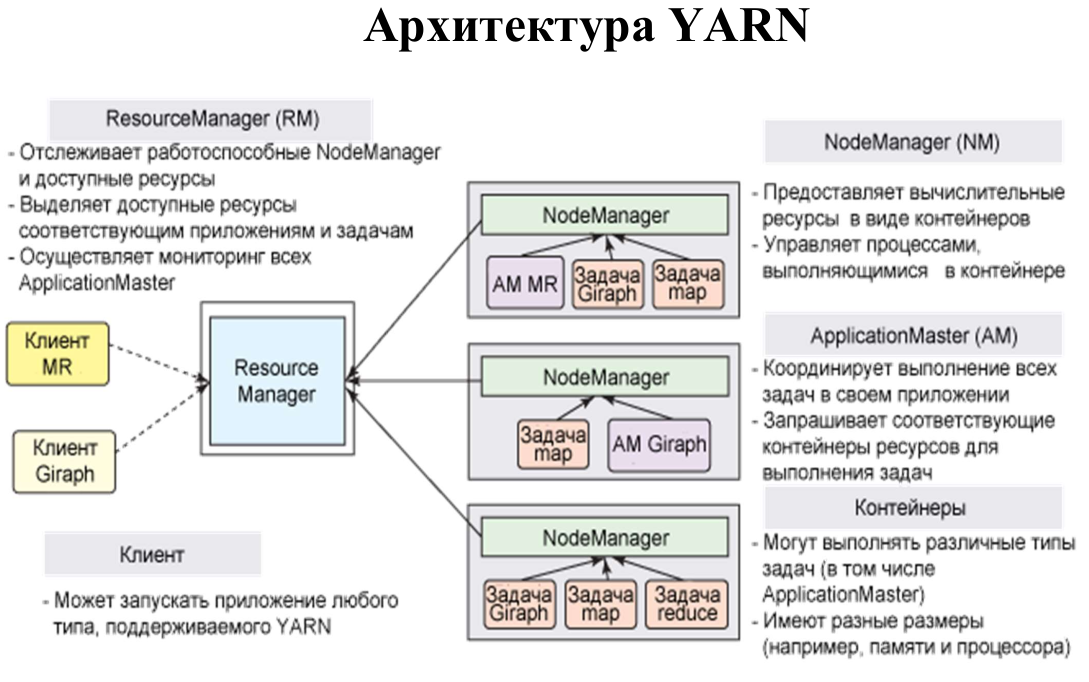

Часть функций было унаследовано, а некоторая часть добавлена.

Вместо JobTracker-а появляется `ResourceManager`, по названию можно понять, что функционала у него стало больше!
- Что он делает можно увидеть на слайде
- Важно что он тут именно отслеживает работоспособность, также как NameNode в HDFS-е получали сообщения от DataNode-ов
- Также ранее JobTracker не выделял доступные ресурсы, он только говорил TaskTracker-у какую задачу ему надо выполнять, это придает гипкости этой архитектуре

Что теперь могут делать клиенты?
- они могут запускать приложение любого типа, поддерживаемого YARN, а ранее они могли запускать только приложения, поддержтваемые map reduce
- теперь же клиент может не заморачиваться над тем, что задача является ли map reduce или нет... Теперь же Resource Manager пострается выполнить задачу, а то как он выполнит: плохо или хорошо, это уже другой вопрос. Это облегчает задачу для программистов

Вместо TaskTracker-а теперь NodeManager:
- он предоставляет вычислительные ресурсы в виде контейнеров
- он управляет процессами выполняющиеся в контейнере

Появляются дополнительные "объекты" AM и Контейнеры
- AM - это аналог TaskTracker-а. Он нужен из-за того, что мы теперь на одну ноду грузим больше задач, т.к. раньше было только  map и reduce, а теперь их больше... Тогда по идее для каждой задачи логично добавить свой AM, который будет координировать выполнение всех задач для конкретного приложения.


![image copy 2.png](<attachment:image copy 2.png>)

про второй пункт мы поговорил сверху - это точно касается очередей 

НО:
- `YARN` тоже ограничен в стратегиях для создания очередей, это исходит из логики: "лучше пожертвовать гибкостью нежеле результатом". Самой плохой случай - это когда система не дает никакго результата и когда он падает, лучше если он дает плохой результат, тогда мы хотя бы можем об этом узнать и исправить...


- YARN находится между HDFS и другими приложениями для обработки данных... (Spark и MapReduce)
- YARN отвязан с физики снизу (HDFS) и он отвязан от логики сверху (SPARK и т.д.), но Spark и MapReduce и т.д. имеют API, который позволяет общаться с YARN-ом

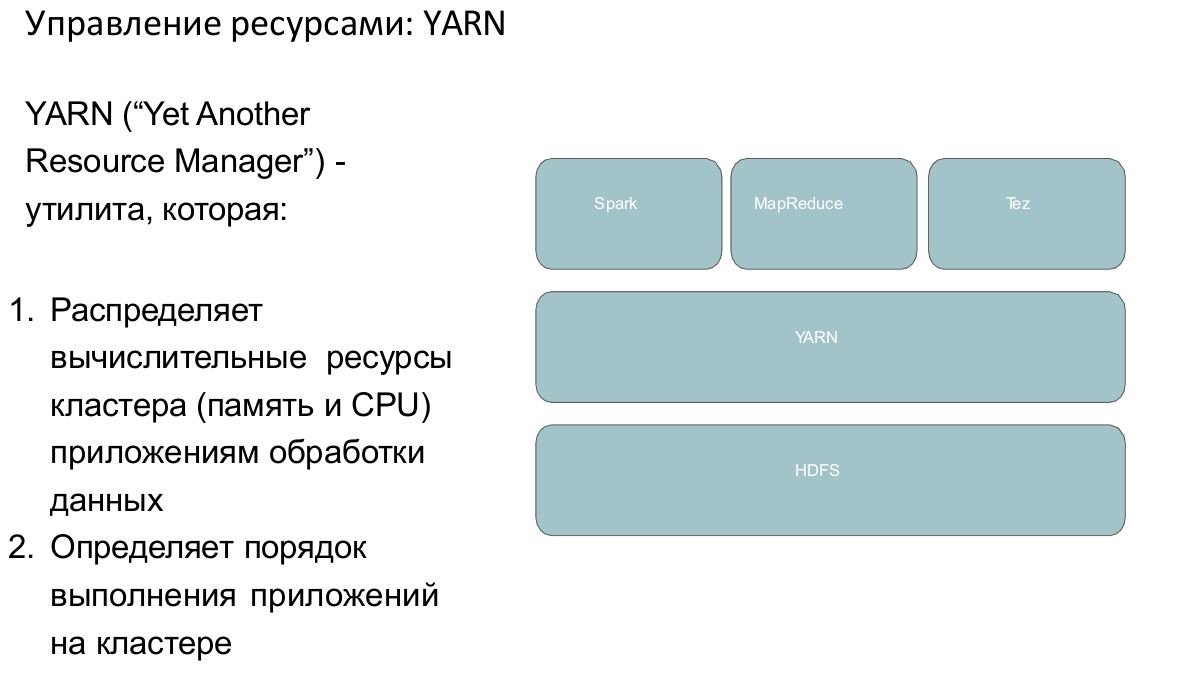

### Как происходит процесс распределения ресурсов?

![image copy 3.png](<attachment:image copy 3.png>)


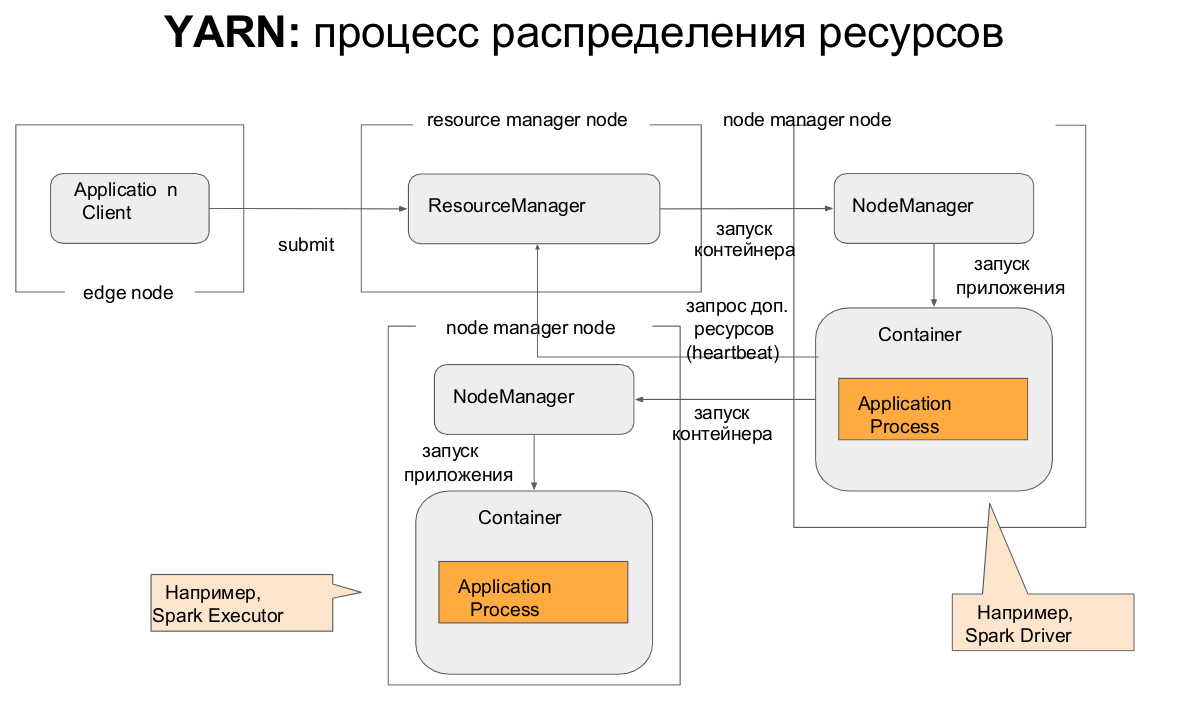

1) У нас есть приложение(Application), который находится на узле клиента.
2) идет обращение (**submit**) к ResourceManager-у, для того чтобы он выделил ему ресурсов на класстерах (которые состоят из нескольких узлов). Он знает про ресурсы которые свободны на каждом узле. (Это информация появляется от Node они кидают ему пакеты по своим ресурсам) и он ведет таблицу, в которой свои записи.
3) дальше он (Resource Manager) обращается к NodeManager-у, который развернут на каждом узле и он активен, для того, чтобы дать команду для запуска контейнера
4) дальше NodeManager берет и запускает приложение в виде контейнера
5) дальше в этом контейнере запускается приложение

<u>Тонкий момент:</u>
- для запуска приложения нужен код этого приложения и пофакту тут мы пилим код под разные контейнеры для выполнения

**YARN** делает запросы от NodeManager-а к ResourceManager-у
- также каждый контейнер может запросить доп ресурсы в случае необходимости, и тогда  ResourceManager уже в другом контейнере выделяет память и выполняет запуск... и Application Process в контейнере, который запросил ресурс будет знать информацию о том где был выделена память под его нужды

### Стратегия распределения ресурсов

### 1) Нарезаем время

![image copy 4.png](<attachment:image copy 4.png>)
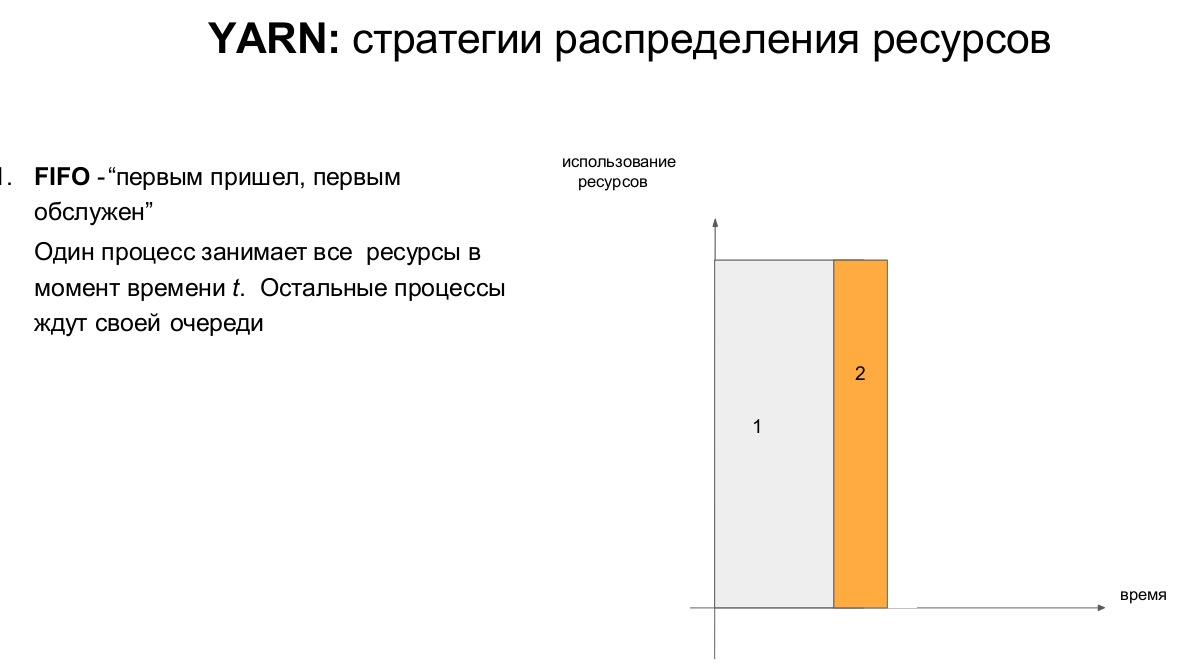

**У нас получается так:**
- пришел клиент ему выдались ресурсы и он занял все свободное пространство в свободном класстере и больше никто не сможет работать в этом класстрере...
- ТУТ ВАЖНО ОГРАНИЧЕВАТЬ YARN иначе он будет занимать все свободное место, свободного класстера. (ТАКЖЕ МОЖНО ИЗМЕНИТЬ СТРАТЕГИЮ FIFO)

**Минусы:**
- приходится ждать тому клиенту, которому не повезло...

**Плюсы:**
- все задачи выполняются быстро, т.к. задействован весь класстер

### 2) Нарезаем ресурсы
![image copy 5.png](<attachment:image copy 5.png>)
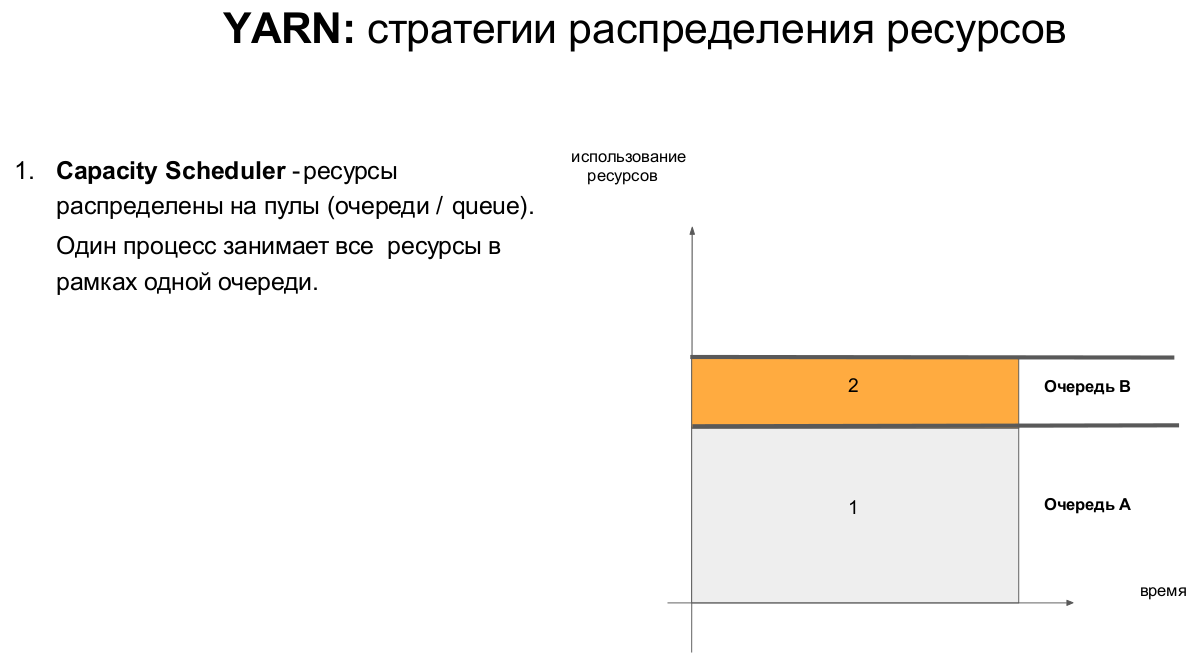

Мы говорим вот этому пользователю выдаем такой ресурс... Стратегыия вроде хорошая, но для определенных задач.

**Минусы:**
- Задача может выполняться очень долго, например программист написал очень плохой код и он выполняется 5 лет...

### 3) Переход от FIFO и CapacitySheduler происходит по мере поступления процессов
- эта стратегия не часто используется, она не очень выгодна...
- это гибкая стратегия...

![image copy 6.png](<attachment:image copy 6.png>)
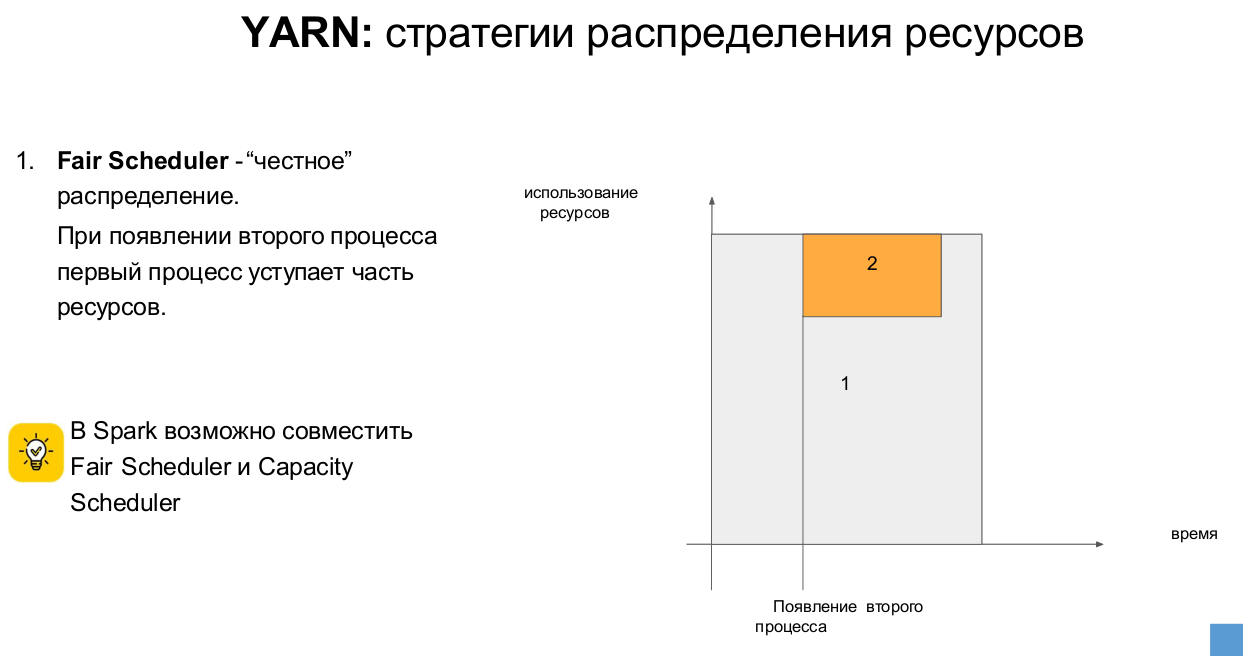

# Как я понял:

Как работает YARN по моему представлению:

1) Есть некий главный узел через который проходят все задачи: RESOURCE MANAGER:
- он отвечает за маиторинг рабочих NodeManager-ов
- он также приоритизирует задачи поступающие от клиентов
- также он смотрит на Application Master - это главная компонента отвечающая за выполнение приложения на NodeManager-е, т.е. он смотрит за тем, чтобы все корректно работало...

2) А NodeManager, как я понимаю это некая "шина", который отвечает за выделение ресурсов на машине и за передачу сообщений между Application Master-ом и контейнерами с приложением...

Ответ от GPT на вопрос правильно ли я понял?

1) По пункту 1: Resource Manager
Вы правы по ключевым аспектам:
- Главный узел: Действительно, Resource Manager (RM) — это центральный управляющий компонент в кластере YARN.[1][2] Он обладает глобальным представлением о всех ресурсах кластера.[1][3]
- Мониторинг NodeManager'ов: Совершенно верно. NodeManager'ы (NM) на рабочих узлах регулярно отправляют "хартбиты" (heartbeats) в RM, сообщая о своем состоянии и использовании ресурсов.[4]
- Приоритизация задач: Да, это одна из ключевых функций. Внутри Resource Manager работает компонент под названием "Планировщик" (Scheduler), который отвечает за распределение ресурсов между различными приложениями в соответствии с их требованиями и настроенными политиками (например, очередями с разными приоритетами).[1][4][5]
- Наблюдение за Application Master: Здесь есть важный нюанс. RM запускает Application Master (AM) для каждого приложения и следит за его состоянием.[4] Если AM выйдет из строя, RM может его перезапустить.[4] Однако, именно Application Master, а не Resource Manager, отвечает за мониторинг выполнения конкретных задач (контейнеров) своего собственного приложения.[4][6]
2) По пункту 2: NodeManager
Ваше описание роли NodeManager в целом верное, но термин "шина" может быть не совсем точным.
- Ответственность за ресурсы на машине: NodeManager — это агент YARN на каждом рабочем узле.[7] Он не сам решает, кому выделить ресурсы, а получает инструкции от Resource Manager. Его главные задачи — это управление - жизненным циклом контейнеров (запуск, остановка) на своем узле, мониторинг использования ресурсов (процессор, память) каждым контейнером и передача этой информации обратно в Resource Manager.[4][6][8]
- Взаимодействие с Application Master: NodeManager действительно является посредником. Application Master, договорившись с Resource Manager о выделении ресурсов на определенном узле, отправляет команду соответствующему NodeManager'у для запуска контейнера с задачей.[9] Затем NM следит за этим контейнером и отчитывается о его статусе как перед RM, так и перед AM.[10]